# Baseline 1
- ResNet18 with pretrained weights

In [1]:
import os
from pathlib import Path

In [2]:
data_path = Path("./data/")
print(os.listdir(data_path))

['eurosat_data.zip', 'sample_submission.csv', 'test', 'train']


In [3]:
train_path = data_path / "train"
test_path = data_path / "test"

In [4]:
classes = os.listdir(train_path)
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [5]:
import pandas as pd

In [6]:
train_images, labels, labels_ixs = [], [], []
for c in classes:
    for img in os.listdir(os.path.join(train_path, c)):
        train_images.append(os.path.join(train_path, c, img))
        labels_ixs.append(classes.index(c))
        labels.append(c)

df = pd.DataFrame({'image': train_images, 'label': labels, 'label_ix': labels_ixs})
df

,image,label,label_ix
0,data\train\AnnualCrop\AnnualCrop_1.jpg,AnnualCrop,0
1,data\train\AnnualCrop\AnnualCrop_100.jpg,AnnualCrop,0
2,data\train\AnnualCrop\AnnualCrop_1000.jpg,AnnualCrop,0
3,data\train\AnnualCrop\AnnualCrop_1001.jpg,AnnualCrop,0
4,data\train\AnnualCrop\AnnualCrop_1002.jpg,AnnualCrop,0
...,...,...,...
21595,data\train\SeaLake\SeaLake_993.jpg,SeaLake,9
21596,data\train\SeaLake\SeaLake_994.jpg,SeaLake,9
21597,data\train\SeaLake\SeaLake_995.jpg,SeaLake,9
21598,data\train\SeaLake\SeaLake_998.jpg,SeaLake,9


In [7]:
test_images = os.listdir(test_path)
len(test_images)

5400

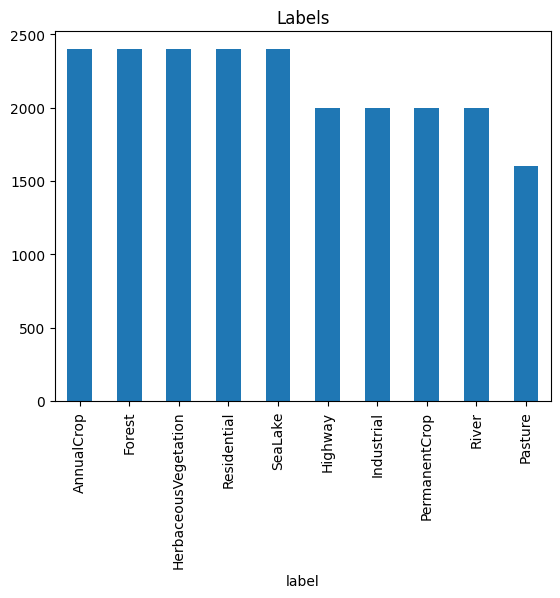

In [10]:
import matplotlib.pyplot as plt

plt.figure()
ax = plt.subplot(1, 1, 1)
df['label'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Labels')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_df.shape, val_df.shape

((17280, 3), (4320, 3))

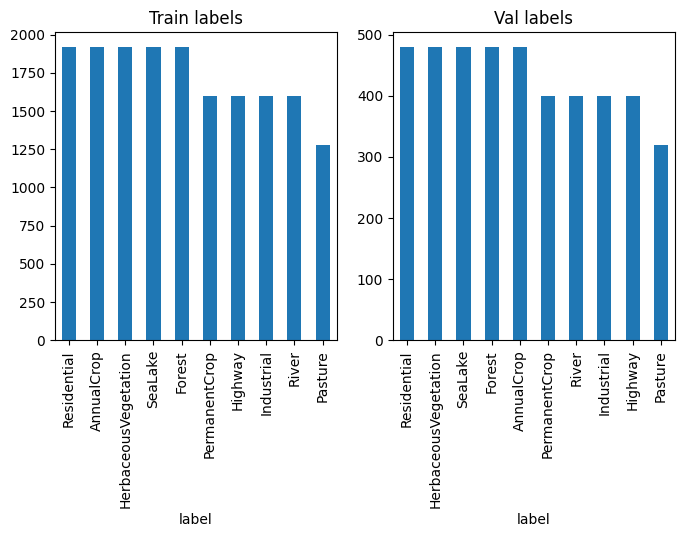

In [13]:
plt.figure(figsize=(8,4))
ax = plt.subplot(1, 2, 1)
train_df['label'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Train labels')
ax = plt.subplot(1, 2, 2)
val_df['label'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Val labels')
plt.show()

In [14]:
from skimage import io

In [16]:
import torch 
from skimage import io
import numpy as np
from torchvision.transforms import v2


class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, trans):
        self.images = images
        self.labels = labels
        self.trans = trans
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        image = io.imread(self.images[index])
        label = self.labels[index]
        # print(type(image))
        image = self.trans(image)
        # print(type(image))

        return image.float() / 255.0, label

In [18]:
from pprint import pprint
import torchvision
import timm
model = timm.create_model('resnet18', pretrained=True, num_classes=len(classes))
data_config = timm.data.resolve_model_data_config(model)

print("Pretrained model data config:")
pprint(data_config)

train_transforms = v2.Compose([
    v2.ToTensor(),
    v2.RandomApply(
        transforms=[
            v2.RandomAffine(degrees=(0, 10),translate=(0, 0.1),
                            # scale=(0.1, 0.2),
                            # interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
                            )
        ], p=0.2,),
    v2.RandomApply(
        transforms=[
            v2.ColorJitter(brightness=.10)
        ], p=0.2,
    ),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    
    v2.Normalize(mean=data_config["mean"], std=data_config["std"]),
])

pred_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=data_config["mean"], std=data_config["std"]),
])

Pretrained model data config:
{'crop_mode': 'center',
 'crop_pct': 0.95,
 'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225)}


In [133]:
ds = {
    'train': Dataset(train_df['image'].values, train_df['label_ix'].values, trans=train_transforms),
    'val': Dataset(val_df['image'].values, val_df['label_ix'].values, trans=pred_transforms),
}

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(ds['val'], batch_size=64, shuffle=False),
}

In [134]:
batch = next(iter(dl['train']))
images, labels = batch

images.shape, labels.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

In [136]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor2 = tensor.detach().clone()
        for t, m, s in zip(tensor2, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor2
# Usando la transformación inversa en tu pipeline
inverse_transform = UnNormalize(mean=data_config["mean"], std=data_config["std"])

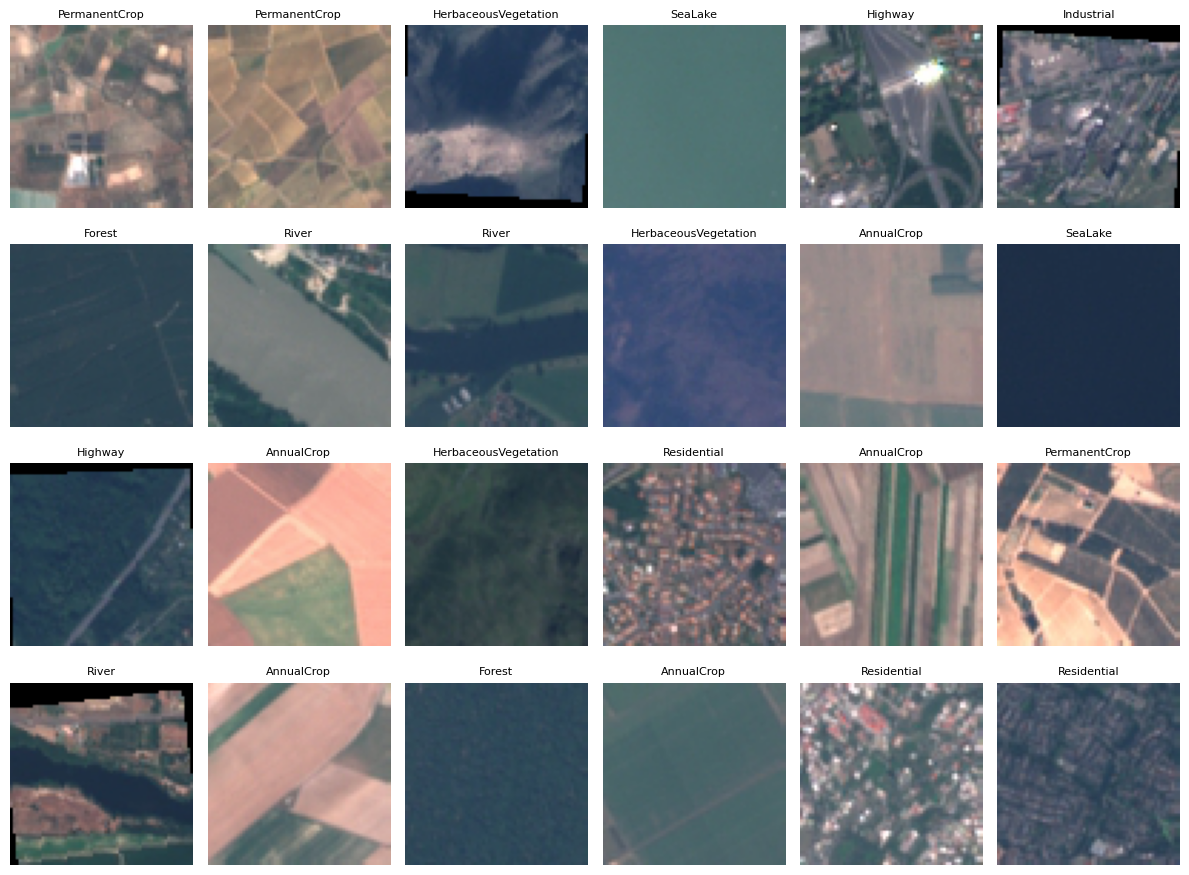

In [144]:
fig = plt.figure(figsize=(12,9))
rows, cols = 4, 6
for i in range(rows * cols):
    ax = plt.subplot(rows, cols, i + 1)
    # ax.imshow(images[i])
    # print(images[i].shape)
    ax.imshow(inverse_transform(images[i]).permute(1,2,0).cpu().numpy())
    ax.set_title(classes[labels[i]], fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [147]:
import timm
import lightning as L
from einops import rearrange

class Module(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('resnet18', pretrained=True, num_classes=len(classes))
        self.loss_fn = torch.nn.CrossEntropyLoss()	
        self.metric = lambda y_hat, y: torch.sum(torch.argmax(y_hat, dim=1) == y).item() / y.shape[0]

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        # return self.model(rearrange(x, 'b h w c -> b c h w'))
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.metric(y_hat, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc',self.metric(y_hat, y), prog_bar=True)

In [150]:
torch.set_float32_matmul_precision('high')

In [152]:
module = Module()

trainer = L.Trainer(
    accelerator="cuda",
    devices=1,
    max_epochs=20,
)

trainer.fit(module, dl['train'], dl['val'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | ResNet           | 11.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Epoch 19: 100%|██████████| 270/270 [01:06<00:00,  4.09it/s, v_num=4, train_acc=0.984, val_acc=0.966]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 270/270 [01:06<00:00,  4.04it/s, v_num=4, train_acc=0.984, val_acc=0.966]


In [160]:
from tqdm import tqdm

module.eval()
module.cuda()

with torch.no_grad():
    preds = []
    for img in tqdm(test_images):
        image = io.imread(os.path.join(test_path, img))
        image = pred_transforms(image).unsqueeze(0)
        # print(image.shape)
        pred = module(image.cuda())
        preds.append(classes[torch.argmax(pred).item()])

        # break
assert len(preds) == len(test_images)














































































































































































































































































































































100%|██████████| 5400/5400 [00:36<00:00, 149.24it/s]


In [161]:
test_df = pd.DataFrame({'image': test_images, 'label': preds})
test_df

,image,label
0,0000.jpg,AnnualCrop
1,0001.jpg,Industrial
2,0002.jpg,AnnualCrop
3,0003.jpg,Forest
4,0004.jpg,Industrial
...,...,...
5395,5395.jpg,Highway
5396,5396.jpg,Industrial
5397,5397.jpg,Forest
5398,5398.jpg,Forest


In [162]:
submissions_path = Path("./submissions/")
submission_name = "submission_2_augment_normalize.csv"
test_df.to_csv(submissions_path / submission_name, index=False)

In [163]:
submission = pd.read_csv(submissions_path / submission_name)
submission

,image,label
0,0000.jpg,AnnualCrop
1,0001.jpg,Industrial
2,0002.jpg,AnnualCrop
3,0003.jpg,Forest
4,0004.jpg,Industrial
...,...,...
5395,5395.jpg,Highway
5396,5396.jpg,Industrial
5397,5397.jpg,Forest
5398,5398.jpg,Forest
